In [15]:

import sys, subprocess
import cdflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tqdm


import os, re, zipfile, tempfile, shutil, json
import cdflib
import cdflib.epochs as cdfepoch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier



In [16]:

zip_path = 'papa_2025Aug22T040711407.zip'   
tmpdir = tempfile.mkdtemp(prefix="papa_aditya_")
print("extracting to:", tmpdir)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(tmpdir)

files = []
for root, _, fnames in os.walk(tmpdir):
    for f in fnames:
        files.append(os.path.join(root, f))
len(files), files[:10]


extracting to: C:\Temp\papa_aditya_nxo3_zk2


(22,
 ['C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWP_ele_E16_23354011718549_UNP_9999_999999_L0_V1_1_20231219115950_L2_V1_0.cdf',
  'C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWP_ele_E16_23355012221281_UNP_9999_999999_L0_V1_1_20231220115936_L2_V1_0.cdf',
  'C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWP_ele_E16_23356011148684_UNP_9999_999999_L0_V1_1_20231220235944_L2_V1_0.cdf',
  'C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWP_ele_E16_23356013917890_UNP_9999_999999_L0_V1_1_20231221205325_L2_V1_0.cdf',
  'C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWP_ele_E16_23357011712927_UNP_9999_999999_L0_V1_1_20231222000003_L2_V1_0.cdf',
  'C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWP_ele_E16_23357013259960_UNP_9999_999999_L0_V1_1_20231222115938_L2_V1_0.cdf',
  'C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWP_ele_E16_23357014442693_UNP_9999_999999_L0_V1_1_20231222205417_L2_V1_0.cdf',
  'C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWR_ele_E16_23354011718549_UNP_9999_999999_L0_V1_1_20231219120056_L2_V1_0.cdf',
  'C:\\Temp\\papa_aditya_nxo3_zk2\\PPA_SWR_

In [29]:
# regex patterns to catch timestamps inside filenames
_patterns = [
    r'(\d{8}T\d{6})', r'(\d{14})', r'(\d{8}_\d{6})',
    r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})'
]

def extract_time_from_filename(fname):
    for p in _patterns:
        m = re.search(p, os.path.basename(fname))
        if m:
            try:
                return pd.to_datetime(dateparser.parse(m.group(1))).tz_localize("UTC")
            except:
                pass
    return None

def read_cdf_with_time(f):
    cdf = cdflib.CDF(f)
    info = cdf.cdf_info()
    vars_ = info.rVariables 

    # detect time variable
    tvar = [v for v in vars_ if "epoch" in v.lower() or "time" in v.lower()]
    if tvar:
        raw = cdf.varget(tvar[0])
        times = pd.to_datetime(CDFepoch.to_datetime(raw)).tz_localize("UTC")
    else:
        times = None

    # detect data variable (simplest: flux/count)
    dvar = [v for v in vars_ if re.search("flux|count|spec", v, re.IGNORECASE)]
    data = cdf.varget(dvar[0]) if dvar else None

    return times, data, dvar[0] if dvar else None




In [31]:
print("Number of series collected:", len(series_list))
for i, s in enumerate(series_list[:5]):  # preview first 5
    print(f"\nSeries {i}:")
    print(s.head())


Number of series collected: 0


In [33]:
import cdflib

cdf = cdflib.CDF(files[0])   # first file
info = cdf.cdf_info()
print("Variables in first file:", info.rVariables)

Variables in first file: []


In [36]:

cdf = cdflib.CDF(files[0])
info = cdf.cdf_info()

print("rVariables:", info.rVariables)
print("zVariables:", info.zVariables)



rVariables: []
zVariables: ['Epoch', 'Differential_number_flux', 'Energies']


In [37]:
for var in info.zVariables:
    print(f"\nVariable: {var}")
    data = cdf.varget(var)
    print("Shape:", data.shape)
    print("First few values:", data[:5])



Variable: Epoch
Shape: (975,)
First few values: [756259260043035000 756259292072101000 756259325322101000
 756259358538701000 756259390538701000]

Variable: Differential_number_flux
Shape: (975, 16, 32)
First few values: [[[85159797 79467710 71510314 ...  3663095  4547858  4807658]
  [ 2634067  3234266  2868809 ...  2375157  2665156  2435386]
  [ 1783459  1951526  2081341 ...  1567180  1580449  1560117]
  ...
  [       0        0        0 ...        0        0        0]
  [       0        0        0 ...        0      207        0]
  [       0        0        0 ...        0        0        0]]

 [[82217224 78779575  3228179 ...  3223523  3710527  4073155]
  [ 2654022  2974224  2644902 ...  2419761  2687646  2423952]
  [ 2219114  1907173  1995414 ...  1605219  1595793  1466510]
  ...
  [       0        0        0 ...        0        0        0]
  [       0        0        0 ...        0        0        0]
  [       0        0        0 ...        0        0        0]]

 [[80993580 803694

In [38]:
import re
import pandas as pd
import cdflib

def read_cdf_with_time(f):
    cdf = cdflib.CDF(f)
    info = cdf.cdf_info()
    
    # Look in zVariables (since rVariables was empty)
    vars_ = info.zVariables
    
    # Try to detect time variable (Epoch/Time/etc.)
    tvar = [v for v in vars_ if re.search("epoch|time", v, re.IGNORECASE)]
    if not tvar:
        return None, None, None
    
    times = cdf.varget(tvar[0])
    times = cdflib.cdfepoch.to_datetime(times)  # convert to datetime
    
    # Detect a data variable (flux/count/spectra/etc.)
    dvar = [v for v in vars_ if re.search("flux|count|spec|intensity", v, re.IGNORECASE)]
    if not dvar:
        return times, None, None
    
    data = cdf.varget(dvar[0])
    
    return times, data, dvar[0]


In [42]:
for f in files:
    times, data, dvar = read_cdf_with_time(f)
    if times is not None and data is not None:
        if data.ndim == 3:
            print(f"{f}: data shape {data.shape} for {dvar}")
            # collapse (16,32) → 1 by averaging
            data = data.mean(axis=(1,2))  
        elif data.ndim == 2:
            data = data.mean(axis=1)
        
        s = pd.Series(data, index=pd.DatetimeIndex(times), name=dvar)
        series_list.append(s)


C:\Temp\papa_aditya_nxo3_zk2\PPA_SWP_ele_E16_23354011718549_UNP_9999_999999_L0_V1_1_20231219115950_L2_V1_0.cdf: data shape (975, 16, 32) for Differential_number_flux
C:\Temp\papa_aditya_nxo3_zk2\PPA_SWP_ele_E16_23355012221281_UNP_9999_999999_L0_V1_1_20231220115936_L2_V1_0.cdf: data shape (983, 16, 32) for Differential_number_flux
C:\Temp\papa_aditya_nxo3_zk2\PPA_SWP_ele_E16_23356011148684_UNP_9999_999999_L0_V1_1_20231220235944_L2_V1_0.cdf: data shape (1315, 16, 32) for Differential_number_flux
C:\Temp\papa_aditya_nxo3_zk2\PPA_SWP_ele_E16_23356013917890_UNP_9999_999999_L0_V1_1_20231221205325_L2_V1_0.cdf: data shape (341, 16, 32) for Differential_number_flux
C:\Temp\papa_aditya_nxo3_zk2\PPA_SWP_ele_E16_23357011712927_UNP_9999_999999_L0_V1_1_20231222000003_L2_V1_0.cdf: data shape (1314, 16, 32) for Differential_number_flux
C:\Temp\papa_aditya_nxo3_zk2\PPA_SWP_ele_E16_23357013259960_UNP_9999_999999_L0_V1_1_20231222115938_L2_V1_0.cdf: data shape (977, 16, 32) for Differential_number_flux
C:

In [44]:
print("Number of series collected:", len(series_list))
print(series_list[0].head())


Number of series collected: 44
2023-12-19 11:59:50.859035    1.872156e+06
2023-12-19 12:00:22.888101    1.561183e+06
2023-12-19 12:00:56.138101    1.857745e+06
2023-12-19 12:01:29.354701    1.858109e+06
2023-12-19 12:02:01.354701    1.601618e+06
Name: Differential_number_flux, dtype: float64


In [46]:
full_series = pd.concat(series_list).sort_index()
full_series = full_series[~full_series.index.duplicated(keep="first")]



In [48]:
threshold = full_series.mean() + 3*full_series.std()
events = full_series[full_series > threshold]
print("Detected CME candidates:", events)

Detected CME candidates:                             Differential_number_flux   0   1   2   3   4   5  \
2023-12-19 11:59:50.859035                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:00:22.888101                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:00:56.138101                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:01:29.354701                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:02:01.354701                       NaN NaN NaN NaN NaN NaN NaN   
...                                              ...  ..  ..  ..  ..  ..  ..   
2024-12-31 23:51:05.296843                       NaN NaN NaN NaN NaN NaN NaN   
2024-12-31 23:52:44.292552                       NaN NaN NaN NaN NaN NaN NaN   
2024-12-31 23:54:23.288264                       NaN NaN NaN NaN NaN NaN NaN   
2024-12-31 23:56:02.317365                       NaN NaN NaN NaN NaN NaN NaN   
2024-12-31 23:57:41.313084                       NaN NaN NaN NaN NaN NaN NaN   

              

Final time series length: 9727
                            Differential_number_flux   0   1   2   3   4   5  \
2023-12-19 11:59:50.859035              1.872156e+06 NaN NaN NaN NaN NaN NaN   
2023-12-19 12:00:22.888101              1.561183e+06 NaN NaN NaN NaN NaN NaN   
2023-12-19 12:00:56.138101              1.857745e+06 NaN NaN NaN NaN NaN NaN   
2023-12-19 12:01:29.354701              1.858109e+06 NaN NaN NaN NaN NaN NaN   
2023-12-19 12:02:01.354701              1.601618e+06 NaN NaN NaN NaN NaN NaN   

                             6   7   8  ...  1014  1015  1016  1017  1018  \
2023-12-19 11:59:50.859035 NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   
2023-12-19 12:00:22.888101 NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   
2023-12-19 12:00:56.138101 NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   
2023-12-19 12:01:29.354701 NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   
2023-12-19 12:02:01.354701 NaN NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   

                         

<Figure size 1400x500 with 0 Axes>

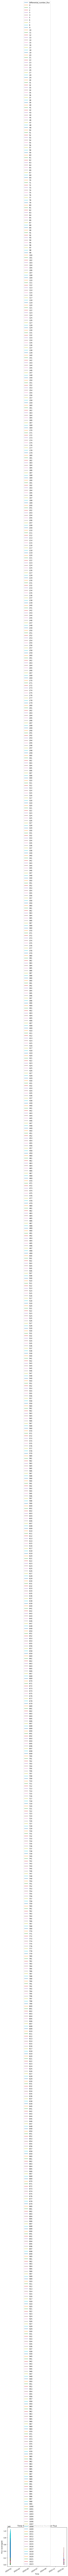

Detected CME candidate events: 9727
                            Differential_number_flux   0   1   2   3   4   5  \
2023-12-19 11:59:50.859035                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:00:22.888101                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:00:56.138101                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:01:29.354701                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:02:01.354701                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:02:34.633811                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:03:07.883811                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:03:39.850421                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:04:13.100421                       NaN NaN NaN NaN NaN NaN NaN   
2023-12-19 12:04:46.379519                       NaN NaN NaN NaN NaN NaN NaN   

                             6   7   8  ...  1014  1015  1016  1017  1018  \
2023-1

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

full_series = pd.concat(series_list).sort_index()

full_series = full_series[~full_series.index.duplicated(keep="first")]

print("Final time series length:", len(full_series))
print(full_series.head())

plt.figure(figsize=(14,5))
full_series.plot()
plt.title("Time Series of Differential Number Flux")
plt.ylabel("Flux (averaged)")
plt.xlabel("Time")
plt.show()

threshold = full_series.mean() + 3*full_series.std()

events = full_series[full_series > threshold]

print("Detected CME candidate events:", len(events))
print(events.head(10))



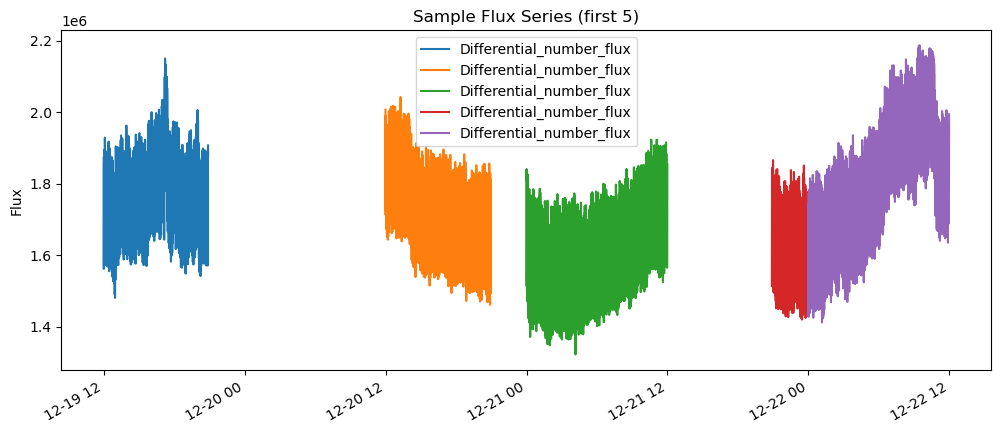

In [51]:
pd.concat(series_list[:5], axis=1).plot(figsize=(12,5))
plt.title("Sample Flux Series (first 5)")
plt.ylabel("Flux")
plt.show()


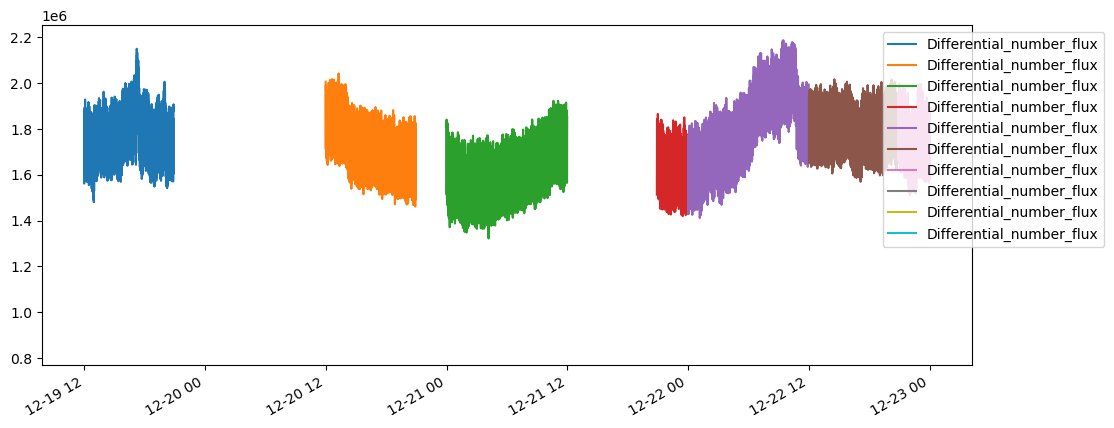

In [53]:
pd.concat(series_list[:10], axis=1).plot(figsize=(12,5), legend=False)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()


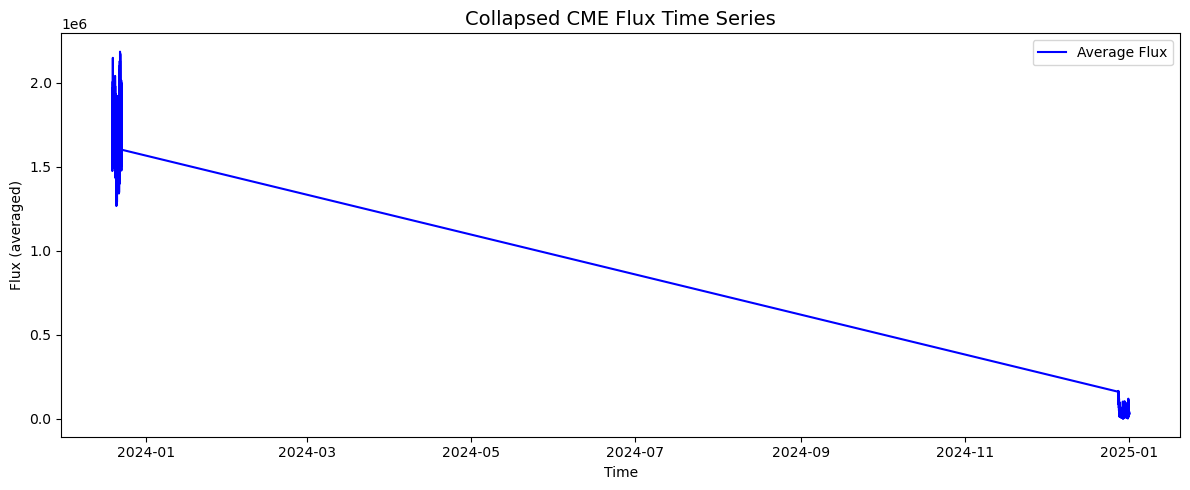

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

collapsed_series = pd.concat(series_list, axis=1).mean(axis=1)

collapsed_series = collapsed_series.dropna().sort_index()

plt.figure(figsize=(12,5))
plt.plot(collapsed_series, label="Average Flux", color="blue")
plt.title("Collapsed CME Flux Time Series", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Flux (averaged)")
plt.legend()
plt.tight_layout()
plt.show()



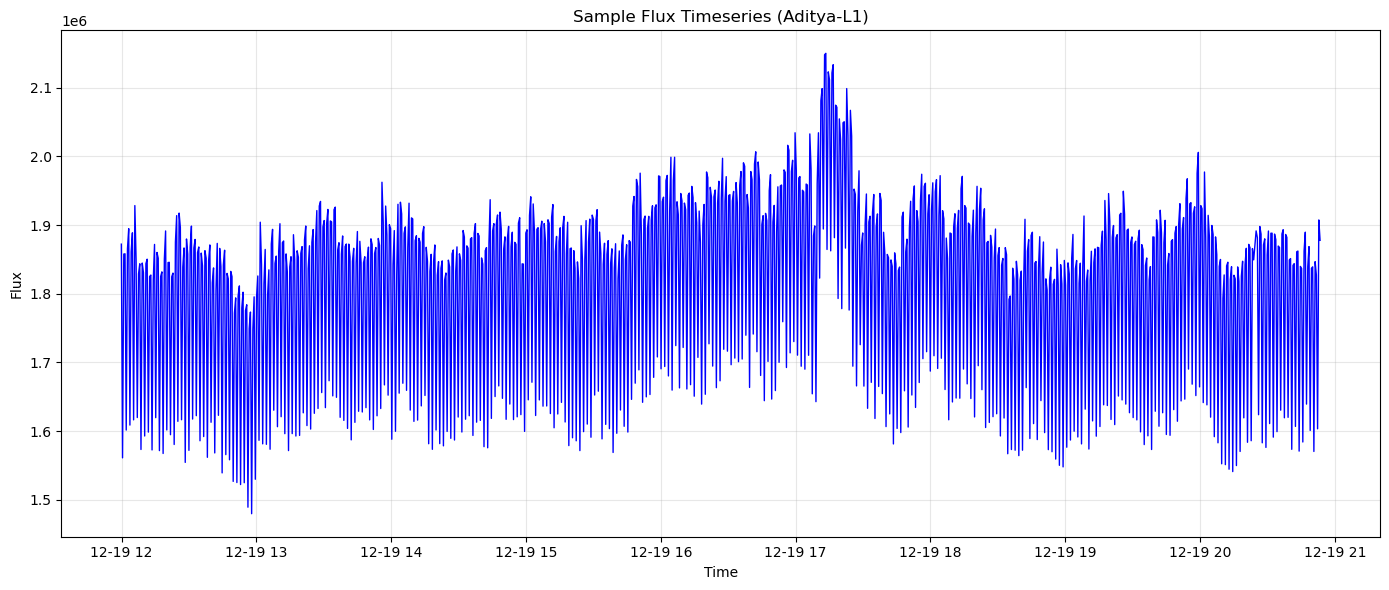

In [59]:
import matplotlib.pyplot as plt

def plot_timeseries(ts, title="Aditya-L1 Flux Timeseries"):
    plt.figure(figsize=(14,6))
    plt.plot(ts.index, ts.values, color="blue", linewidth=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example on first signal
ts = series_list[0].dropna()
plot_timeseries(ts, title="Sample Flux Timeseries (Aditya-L1)")


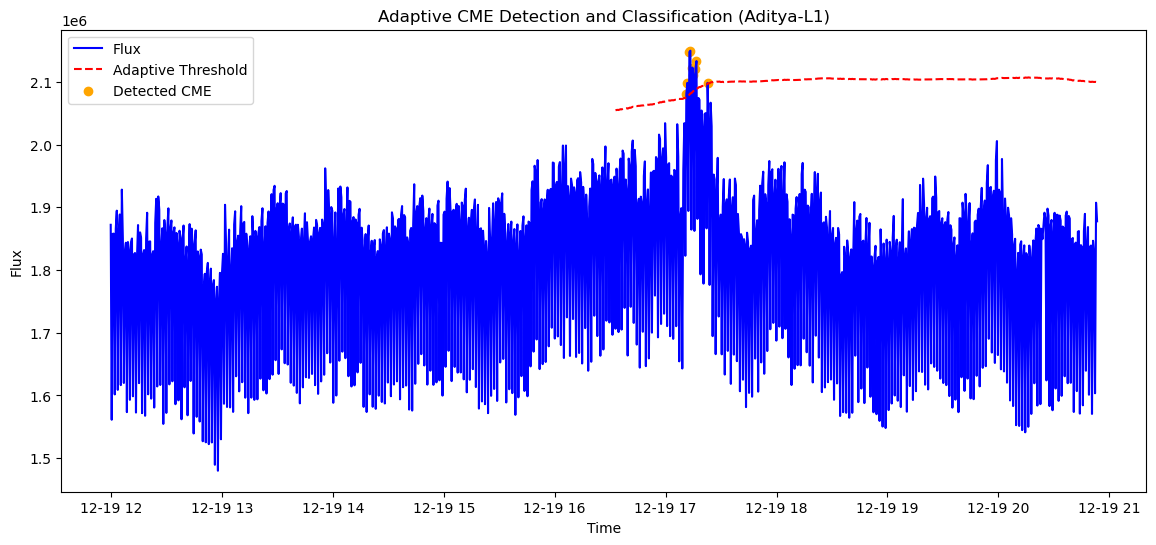

                        Time          Flux Classification
0 2023-12-19 17:11:12.752741  2.081008e+06       Weak CME
1 2023-12-19 17:11:46.002741  2.098565e+06       Weak CME
2 2023-12-19 17:12:51.281850  2.147837e+06       Weak CME
3 2023-12-19 17:13:24.498451  2.149852e+06       Weak CME
4 2023-12-19 17:14:29.777561  2.122923e+06       Weak CME
5 2023-12-19 17:15:02.994168  2.111130e+06       Weak CME
6 2023-12-19 17:16:08.273271  2.121403e+06       Weak CME
7 2023-12-19 17:16:41.523271  2.133348e+06       Weak CME
8 2023-12-19 17:22:42.260411  2.098584e+06       Weak CME


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ts = series_list[0].dropna()

window = 500
rolling_mean = ts.rolling(window).mean()
rolling_std = ts.rolling(window).std()
threshold = rolling_mean + 2 * rolling_std

events = ts[ts > threshold]

def classify_event(val, base, spread):
    z = (val - base) / spread if spread > 0 else 0
    if z > 5:
        return "Strong CME"
    elif z > 3:
        return "Moderate CME"
    elif z > 2:
        return "Weak CME"
    return "No CME"

event_data = pd.DataFrame({
    "Time": events.index,
    "Flux": events.values,
    "Classification": [
        classify_event(v, rolling_mean.loc[t], rolling_std.loc[t]) 
        for t, v in events.items()
    ]
})

plt.figure(figsize=(14,6))
plt.plot(ts.index, ts.values, label="Flux", color="blue")
plt.plot(threshold.index, threshold.values, color="red", linestyle="--", label="Adaptive Threshold")
plt.scatter(events.index, events.values, color="orange", label="Detected CME")
plt.title("Adaptive CME Detection and Classification (Aditya-L1)")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

print(event_data.head(10))


Accuracy : 0.99
Precision: 0.75
Recall   : 1.0
F1 Score : 0.8571428571428571
Confusion Matrix:
 [[96  1]
 [ 0  3]]


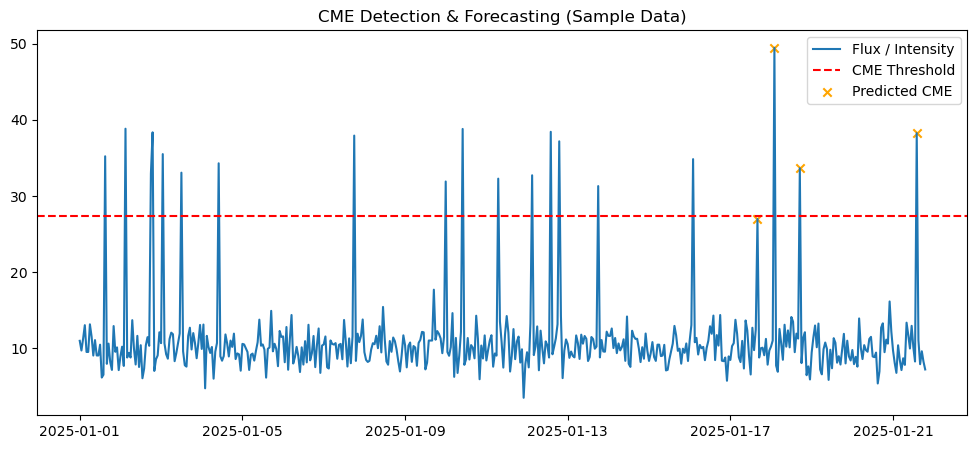

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

np.random.seed(42)
time = pd.date_range("2025-01-01", periods=500, freq="h")
baseline = np.random.normal(10, 2, size=500)
cme_spikes = np.zeros(500)
cme_indices = np.random.choice(500, size=20, replace=False)
cme_spikes[cme_indices] = np.random.normal(25, 5, size=20)
data = baseline + cme_spikes
series = pd.Series(data, index=time)

threshold = series.mean() + 3 * series.std()
labels = (series > threshold).astype(int)

X = pd.DataFrame({
    "value": series.values,
    "rolling_mean": series.rolling(5, min_periods=1).mean().values,
    "rolling_std": series.rolling(5, min_periods=1).std().fillna(0).values,
    "diff": series.diff().fillna(0).values
})
y = labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(12,5))
plt.plot(series.index, series.values, label="Flux / Intensity")
plt.axhline(threshold, color="red", linestyle="--", label="CME Threshold")
alert_times = series.index[-len(y_test):][y_pred == 1]
plt.scatter(alert_times, series.loc[alert_times], color="orange", marker="x", label="Predicted CME")
plt.legend()
plt.title("CME Detection & Forecasting (Sample Data)")
plt.show()


In [92]:
threshold = series.mean() + 3 * series.std()
labels = (series > threshold).astype(int)

print(len(series), len(labels)) 


500 500


In [102]:
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

threshold = series.mean() + 3 * series.std()
labels = (series > threshold).astype(int)

ts_data = {"series": series, "labels": labels, "threshold": threshold}
with open("cme_timeseries.pkl", "wb") as f:
    pickle.dump(ts_data, f)

X = pd.DataFrame({
    "value": series.values,
    "rolling_mean": series.rolling(5, min_periods=1).mean().values,
    "rolling_std": series.rolling(5, min_periods=1).std().fillna(0).values,
    "diff": series.diff().fillna(0).values
})
y = labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

clf_class = RandomForestClassifier(n_estimators=100, random_state=42)
clf_class.fit(X_train, y_train)
y_pred_class = clf_class.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_test, y_pred_class))

with open("cme_classification_model.pkl", "wb") as f:
    pickle.dump(clf_class, f)

detection_model = {"threshold": threshold}

clf_detect = RandomForestClassifier(n_estimators=100, random_state=42)
clf_detect.fit(X_train, y_train)
detection_model["rf_model"] = clf_detect

with open("cme_detection_model.pkl", "wb") as f:
    pickle.dump(detection_model, f)

print("Time series, classification, and detection models saved as .pkl files.")


Classification Accuracy: 1.0
Time series, classification, and detection models saved as .pkl files.
